**We fetch the data**

We select one city to start with

In [67]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd



data = pd.read_csv('listings_copenhagen.csv.gz', compression='gzip')

data = data[['accommodates','bathrooms_text','bedrooms', 'beds', 'review_scores_rating','review_scores_location','review_scores_value','reviews_per_month','number_of_reviews','calculated_host_listings_count','minimum_nights','availability_90','amenities','property_type','room_type','price']]

# data = data[['accommodates','bedrooms','price']]
data = data.dropna()
data.shape



(11813, 16)

**We define a function to change string features to an integer**

In [68]:
def string_features_to_num(array):
    dictOfWords = { i : np.unique(array)[i] for i in range(0, len(np.unique(array)) ) }
    dictOfWords = {v: k for k, v in dictOfWords.items()}
    
    values = np.zeros(len(array))
    for i in range(len(array)):
        values[i] = dictOfWords.get(array[i])
        
    return values, dictOfWords

In [69]:
def selectPropertyType(type, X, y):
    xlist = []
    ylist = []
    for i in range(X.shape[0]):
        if(X[i,-2] == type):
            xlist.append(X[i,:])
            ylist.append(y[i])
    return np.array(xlist), np.array(ylist)

In [70]:
def oneHotEncodingPropertyType(type, X):
    isType = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        if(X[i,-2] == type):
            isType[i] = 1.0
    return np.hstack((X, isType.reshape(-1,1)))

In [71]:
import matplotlib.pyplot as plt

def plotPredVsReal(yreal, ypred, limit):
    plt.scatter(yreal, ypred, label="pred vs true")
    plt.plot(yreal, yreal, label="y=x")
    plt.xlabel("y-real")
    plt.ylabel("y-pred")
    plt.xlim((0,limit))
    plt.ylim((0,limit))
    plt.legend()
    plt.show


In [72]:
def plotFeatureVsPrice(feature, price):
    plt.scatter(feature, price)
    plt.ylabel("price")
    plt.show()


**Data split into features and target**

We also change the target from a string to a float. 

{'Boat': 0, 'Camper/RV': 1, 'Entire bungalow': 2, 'Entire cabin': 3, 'Entire condo': 4, 'Entire cottage': 5, 'Entire guest suite': 6, 'Entire guesthouse': 7, 'Entire home': 8, 'Entire loft': 9, 'Entire place': 10, 'Entire rental unit': 11, 'Entire serviced apartment': 12, 'Entire townhouse': 13, 'Entire vacation home': 14, 'Entire villa': 15, 'Houseboat': 16, 'Hut': 17, 'Private room': 18, 'Private room in bed and breakfast': 19, 'Private room in boat': 20, 'Private room in bungalow': 21, 'Private room in casa particular': 22, 'Private room in condo': 23, 'Private room in guest suite': 24, 'Private room in guesthouse': 25, 'Private room in home': 26, 'Private room in hostel': 27, 'Private room in hut': 28, 'Private room in loft': 29, 'Private room in rental unit': 30, 'Private room in serviced apartment': 31, 'Private room in tiny home': 32, 'Private room in townhouse': 33, 'Private room in vacation home': 34, 'Private room in villa': 35, 'Room in aparthotel': 36, 'Room in boutique hot

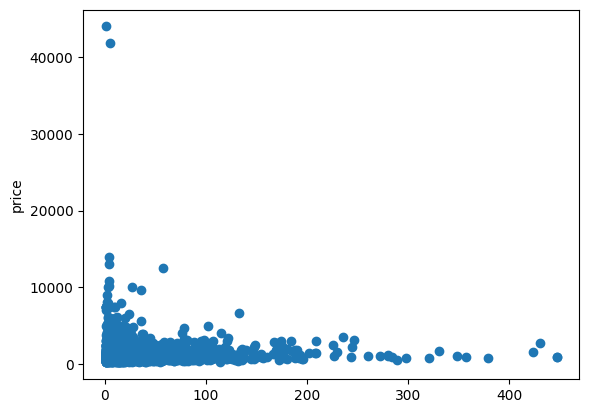

(5352, 13)

In [91]:
import re

datanp = np.array(data)
X = datanp[:,:-1]
y = datanp[:,-1]

bathroomErr = []
for i in range(X.shape[0]):
    try:
        X[i,1] = float(X[i,1].split()[0])
    except ValueError:
        bathroomErr.append(i)
bathroomErr = np.array(bathroomErr)
X = np.delete(X, bathroomErr, axis=0)
y = np.delete(y, bathroomErr)

for i in range(len(y)):
    y[i] = float(re.sub(",", "", (y[i][1:])))



X[:, -2], propertytype_dict = string_features_to_num(X[:, -2])
X[:, -1], roomtype_dict = string_features_to_num(X[:, -1])

print(propertytype_dict)
print(list(enumerate(np.bincount(np.array(X[:, -2],dtype='int64')))))

X, y = selectPropertyType(propertytype_dict.get('Entire rental unit'), X, y)

X = X[:,:X.shape[1]-2]

# X = oneHotEncodingPropertyType(propertytype_dict.get('Entire rental unit'), X)
# X = oneHotEncodingPropertyType(propertytype_dict.get('Entire condo'), X)
# X = oneHotEncodingPropertyType(propertytype_dict.get('Private room in rental unit'), X)

plotFeatureVsPrice(X[:,8], y[:])

X.shape


In [74]:
import ast 

def amenitiesOneHot(X, amenityName):
    amenities = []
    for i in range(X.shape[0]):
        amenities.append(ast.literal_eval(X[i,-1]))

    amenity = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        for j in range(len(amenities[i])):
            if(amenities[i][j]==amenityName):
                amenity[i] = 1
    return amenity

**One Hot encoded features added**

In [75]:
# np.sum(amenitiesOneHot(X, 'Private patio or balcony'))/X.shape[0]


patio = amenitiesOneHot(X, 'Private patio or balcony')
tv = amenitiesOneHot(X, 'TV')
wifi = amenitiesOneHot(X, 'Wifi')
bedlinens = amenitiesOneHot(X, 'Bed linens')
breakfast = amenitiesOneHot(X, 'Breakfast')
bathtub = amenitiesOneHot(X, 'Bathtub')
washer = amenitiesOneHot(X, 'Washer')
elevator = amenitiesOneHot(X, 'Elevator')

onehot = np.hstack((tv.reshape(-1,1), patio.reshape(-1,1)))
onehot = np.hstack((onehot, wifi.reshape(-1,1)))
onehot = np.hstack((onehot, bedlinens.reshape(-1,1)))
onehot = np.hstack((onehot, breakfast.reshape(-1,1)))
onehot = np.hstack((onehot, bathtub.reshape(-1,1)))
onehot = np.hstack((onehot, washer.reshape(-1,1)))
onehot = np.hstack((onehot, elevator.reshape(-1,1)))


X = X[:,:-1]
X = np.hstack((X, onehot))
X.shape

(5352, 20)

In [76]:
# a = amenitiesOneHot(X, 'Elevator')
# print(np.sum(a))

# amenities = []
# for i in range(X.shape[0]):
#     amenities.append(ast.literal_eval(X[i,-1]))
# print(amenities)

**Data split into train/val/test**

In [77]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

**Models imported**

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

linear_model = LinearRegression()
svr_model = SVR(C=60, epsilon=0.95)

**Models fit and scored**

We fit the models on the training set and test with the linear regression. 

Training score:  0.19871709547558825
Test score:  0.34130985179935613
Validation score:  0.059948457985429915


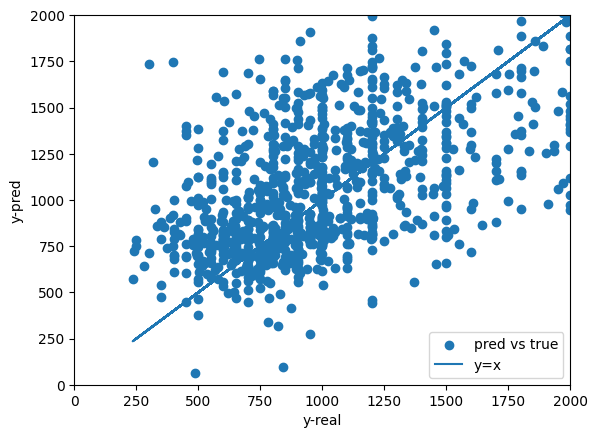

In [79]:
linear_model.fit(X_train, y_train)
linear_train_score = linear_model.score(X_train, y_train)
linear_val_score = linear_model.score(X_val,y_val)
linear_test_score = linear_model.score(X_test,y_test)

print("Training score: ", linear_train_score)
print("Test score: ", linear_test_score)
print("Validation score: ", linear_val_score)

plotPredVsReal(y_test, linear_model.predict(X_test), 2000)

In [80]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)



Training score:  0.2602214167351311
Test score:  0.2602214167351311
Validation score:  0.2602214167351311


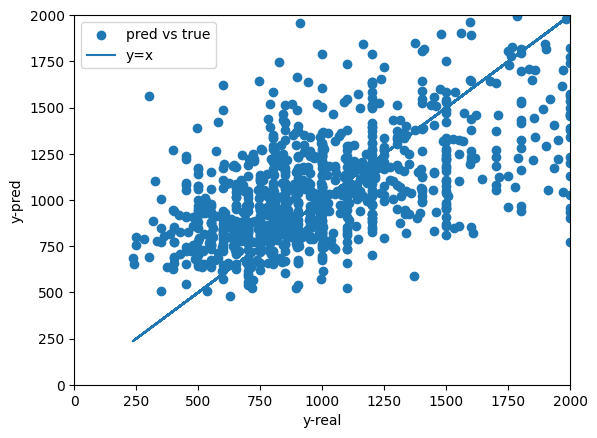

In [81]:
from sklearn.svm import NuSVR

svr_model = NuSVR(C=600, nu=0.3)
svr_model.fit(X_train, y_train)
svr_train_score = svr_model.score(X_test, y_test)
svr_test_score = svr_model.score(X_test, y_test)
svr_val_score = svr_model.score(X_test, y_test)
print("Training score: ", svr_train_score)
print("Test score: ", svr_test_score)
print("Validation score: ", svr_val_score)

plotPredVsReal(y_test, svr_model.predict(X_test), 2000)


Training score:  0.4723488993351673
Test score:  0.4723488993351673
Validation score:  0.4723488993351673


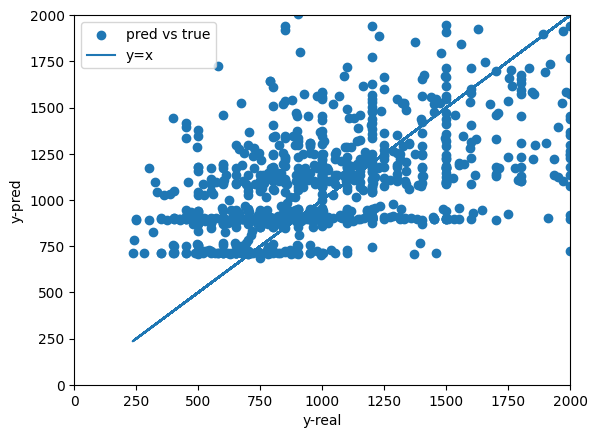

In [82]:
from sklearn.ensemble import RandomForestRegressor

regr_model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=100)
regr_model.fit(X_train, y_train)

regr_train_score = regr_model.score(X_test, y_test)
regr_test_score = regr_model.score(X_test, y_test)
regr_val_score = regr_model.score(X_test, y_test)

print("Training score: ", regr_train_score)
print("Test score: ", regr_test_score)
print("Validation score: ", regr_val_score)


plotPredVsReal(y_test, regr_model.predict(X_test), 2000)


In [83]:
from sklearn.linear_model import Ridge


clf_model = Ridge(alpha=5)
clf_model.fit(X_train, y_train)

clf_train_score = clf_model.score(X_test, y_test)
clf_test_score = clf_model.score(X_test, y_test)
clf_val_score = clf_model.score(X_test, y_test)

print("Training score: ", clf_train_score)
print("Test score: ", clf_test_score)
print("Validation score: ", clf_val_score)

Training score:  0.34124123478213575
Test score:  0.34124123478213575
Validation score:  0.34124123478213575



Training r2: 0.9778
Validation r2: -0.3202


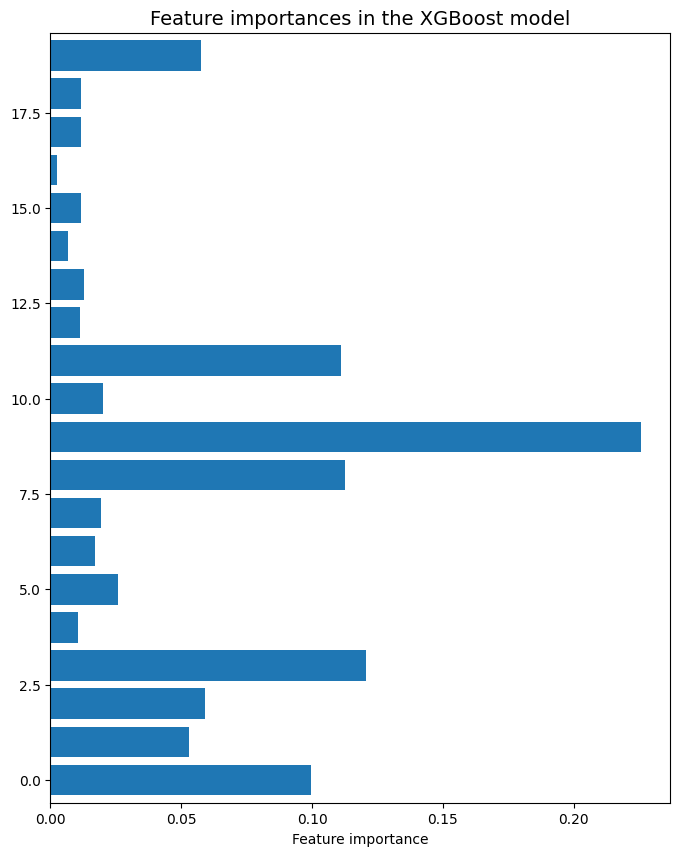

In [84]:
import math
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import xgboost as xgb



X_train = pd.DataFrame(X_train, dtype='float')
X_test = pd.DataFrame(X_test, dtype='float')
y_train = pd.DataFrame(y_train, dtype='float')
y_test = pd.DataFrame(y_test, dtype='float')

# Fitting the model
# learning_rate=0.12, max_depth=4, n_estimators=20
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results

print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,10))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()



In [85]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import r2_score

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

def scale_datasets(x_train, x_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    standard_scaler = StandardScaler()
    x_train_scaled = pd.DataFrame(
        standard_scaler.fit_transform(x_train),
        columns=x_train.columns
    )
    x_test_scaled = pd.DataFrame(
        standard_scaler.transform(x_test),
        columns = x_test.columns
    )
    return x_train_scaled, x_test_scaled
x_train_scaled, x_test_scaled = scale_datasets(X_train, X_test)

In [86]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 1e-3
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [87]:
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle]
)
# train the model
history = model.fit(
    x_train_scaled.values, 
    np.asarray(y_train.values).astype('float32'), 
    epochs=20, 
    batch_size=8,
    validation_split=0.2
)

Epoch 1/20


2022-11-09 18:33:51.250544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - ETA: 0s - loss: 3.9041 - mean_squared_logarithmic_error: 3.9041

2022-11-09 18:33:53.723920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


321/321 [==============================] - 3s 7ms/step - loss: 3.9041 - mean_squared_logarithmic_error: 3.9041 - val_loss: 0.1578 - val_mean_squared_logarithmic_error: 0.1581
Epoch 2/20
321/321 [==============================] - 2s 6ms/step - loss: 0.1649 - mean_squared_logarithmic_error: 0.1649 - val_loss: 0.1344 - val_mean_squared_logarithmic_error: 0.1339
Epoch 3/20
321/321 [==============================] - 2s 6ms/step - loss: 0.1502 - mean_squared_logarithmic_error: 0.1502 - val_loss: 0.1331 - val_mean_squared_logarithmic_error: 0.1324
Epoch 4/20
321/321 [==============================] - 2s 7ms/step - loss: 0.1445 - mean_squared_logarithmic_error: 0.1445 - val_loss: 0.1320 - val_mean_squared_logarithmic_error: 0.1313
Epoch 5/20
321/321 [==============================] - 2s 7ms/step - loss: 0.1391 - mean_squared_logarithmic_error: 0.1391 - val_loss: 0.1296 - val_mean_squared_logarithmic_error: 0.1287
Epoch 6/20
321/321 [==============================] - 3s 10ms/step - loss: 0.1358

KeyboardInterrupt: 

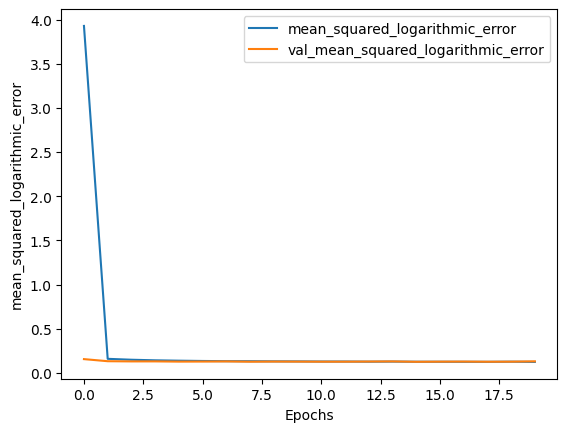

34/34 [==============================] - 0s 3ms/step


2022-11-09 18:28:22.244507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 0s 2ms/step


0.3278407866616244

In [ ]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

X_test['prediction'] = model.predict(x_test_scaled)

r2_score(y_test, model.predict(x_test_scaled))
